In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from tqdm import tqdm

## Поиск минимума сетке

In [4]:
m1 = 2e30
m2 = 8.7e25
r2 = 25560
r12 = 2871*1e6
v2 = 6.8
m3 = 3e21
r3 = 761
r23 = 584e3
v3 = 3.15

In [5]:
g = 6.67430e-11/1e9

In [6]:
x1, y1 = 0, 0
vx1, vy1 = 0, 0
x2, y2 = r12, 0
x3, y3 = r12+r23, 0
vx2, vy2 = 0, v2
vx3, vy3 = 0, v2+v3

In [7]:
def f_gr(p1, p2):
    return g*(p2 - p1)/(np.linalg.norm(p1 - p2))**3

In [8]:
def rot_angle(a, b):
    _a = a / np.linalg.norm(a)
    _b = b / np.linalg.norm(b)
    ang = np.arccos((_a @ _b))
    _c = _b @ np.array([[np.cos(ang), np.sin(ang)], [-np.sin(ang), np.cos(ang)]])
    _d = _b @ np.array([[np.cos(-ang), np.sin(-ang)], [-np.sin(-ang), np.cos(-ang)]])
    if (_c @ _a) < (_d @ _a):
        return -ang
    else:
        return ang

In [9]:
all_data = None
fuel_off_idx = None
orb_idx = -1
coll_idx = -1
orb = False     # достиг орбиты
coll = False    # попал

In [10]:
m_pg = 55.  # масса полезного груза
t_fuel = 2250.
h = 430.
u = 3.160   # скорость выброса топлива
alpha = 0.025   # доля конструкции

In [11]:
# t_end = 60*60*24*30685.4
t_end = t_fuel * 1000
n = 1000
dt = t_end / n

In [12]:
m_fuel_min = 320.
m_fuel_max = 370.

In [13]:
plot_traj = True
plot_every_traj = False

In [14]:
sector_num = 360
dm = 0.25

In [15]:
ang_arr = np.linspace(0, 2*np.pi, sector_num+1)[:-1]
m_fuel_arr = np.array([-1.]*sector_num)

In [16]:
has_coll_arr = [False]*sector_num

In [17]:
optim_fuel = m_fuel_max

In [79]:
np.sqrt(g*m2/(r2+h)) # первая космическая

14.947182887089458

  0%|          | 0/360 [00:00<?, ?it/s]

 81%|████████  | 292/360 [9:02:43<1:14:23, 65.64s/it]  

(756, 16)


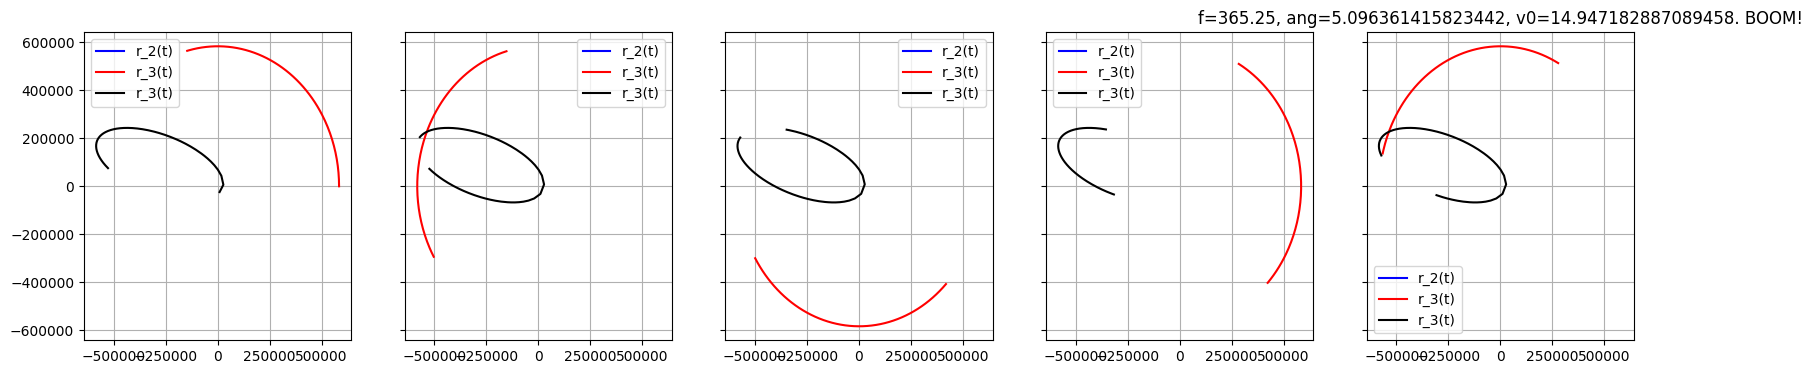

 84%|████████▍ | 302/360 [9:13:10<1:00:33, 62.65s/it]

(768, 16)


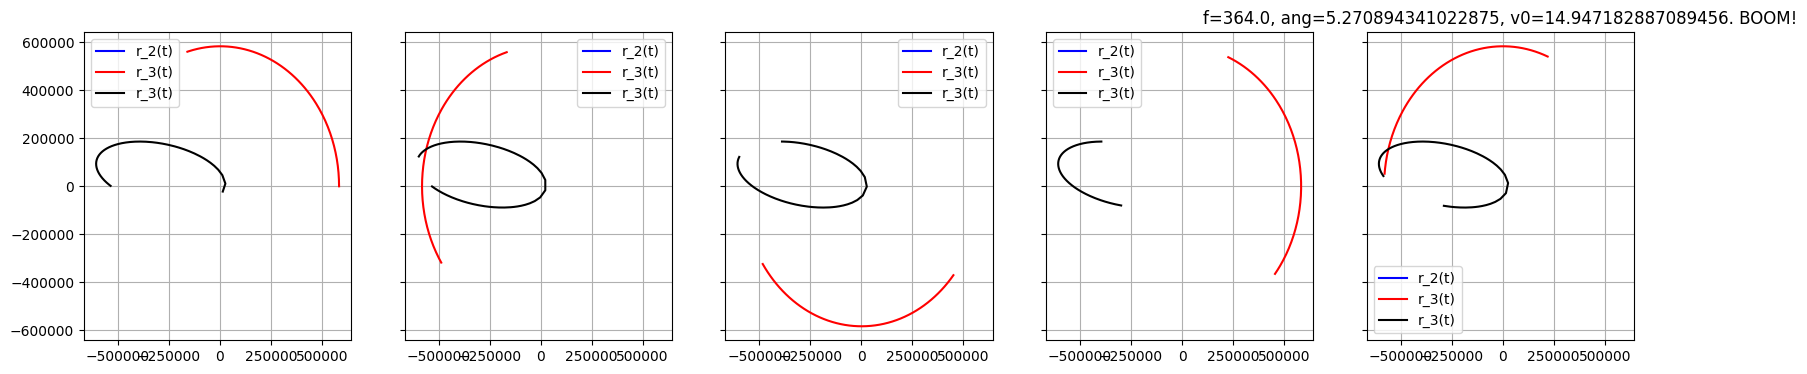

100%|██████████| 360/360 [10:21:25<00:00, 103.57s/it]


In [45]:
for i in tqdm(range(sector_num)):
    cur_ang = ang_arr[i]
    cur_m_fuel_0 = m_fuel_min

    while cur_m_fuel_0 <= m_fuel_max:
        # print(cur_m_fuel_0)

        m_cons = alpha * (cur_m_fuel_0 + m_pg) / (1 - alpha)

        def m_fuel(t):
            return 0 if t > t_fuel else cur_m_fuel_0 * (t_fuel - t)/t_fuel

        def m_r(t):
            return m_fuel(t) + m_cons + m_pg

        def f_react(t, v):
            return np.zeros(2) if t > t_fuel else v * u * cur_m_fuel_0 / (t_fuel*np.linalg.norm(v)*m_r(t))

        def system_full(y, t):
            dydt0, dydt1, dydt2, dydt3, dydt4, dydt5, dydt6, dydt7 = y[8:]
            f_12 = f_gr(y[0:2], y[2:4])
            f_13 = f_gr(y[0:2], y[4:6])
            f_1r = f_gr(y[0:2], y[6:8])
            f_23 = f_gr(y[2:4], y[4:6])
            f_2r = f_gr(y[2:4], y[6:8])
            f_3r = f_gr(y[4:6], y[6:8])
            dydt8, dydt9 = m2*f_12 + m3*f_13 + m_r(t)*f_1r
            dydt10, dydt11 = -m1*f_12 + m3*f_23 + m_r(t)*f_2r
            dydt12, dydt13 = -m1*f_13 - m2*f_23 + m_r(t)*f_3r
            dydt14, dydt15 =  -m1*f_1r - m2*f_2r -m3*f_3r + f_react(t, y[14:16])
            return np.array([dydt0, dydt1, dydt2, dydt3, dydt4, dydt5, dydt6, dydt7, dydt8, dydt9, dydt10, dydt11, dydt12, dydt13, dydt14, dydt15])

        r_r_init = np.array([r12, 0]) + np.array([r2+h, 0]) @ np.array([[np.cos(cur_ang), np.sin(cur_ang)], [-np.sin(cur_ang), np.cos(cur_ang)]])
        v_r_init = np.array([0, v2]) + np.array([0, np.sqrt(g*m2/(r2+h))]) @ np.array([[np.cos(cur_ang), np.sin(cur_ang)], [-np.sin(cur_ang), np.cos(cur_ang)]])
        init_cond = np.array([0,0, r12, 0, r12+r23, 0, r_r_init[0], r_r_init[1], 0, 0, 0, v2, 0, v2+v3, v_r_init[0], v_r_init[1]])

        # init_cond = np.array([0,0, r12, 0, r12+r23, 0, r12+r2+h, 0, 0, 0, 0, v2, 0, v2+v3, 0, v2+np.sqrt(g*m2/(r2+h))])
        assert len(init_cond) == 16

        y_cur = init_cond.copy()
        t_cur = 0.
        # all_data = np.zeros((n, 16))

        # orb_idx = -1
        coll_idx = -1
        # orb = False
        coll = False

        t_eval = np.linspace(0, t_end, n+1)
        sol = odeint(system_full, init_cond, t_eval)

        for j in range(n):
            if np.linalg.norm(sol[j,4:6] - sol[j,6:8]) <= r3:
                coll_idx = j
                coll = True
                break
            # dist = np.linalg.norm(sol[j,2:4] - sol[j,6:8])
            # if max_r_2r < dist:
            #     max_r_2r = dist
            # elif (dist < max_r_2r) and (max_r_2r < (r23 - r3)):
            #     break

        if plot_every_traj and (425 < cur_m_fuel_0 < 427):
            # Plot the solution
            frames = 5
            fig, ax = plt.subplots(1, frames, figsize = (4*frames, 4), sharex=True, sharey=True)
            all_data = sol
            if coll:
                all_data = all_data[:coll_idx]
            idxs = list(map(int, np.linspace(0, len(all_data)-1, frames+1)))
            print(all_data.shape)
            for fr, idx in enumerate(idxs[1:]):
                draw_data = all_data[idxs[fr]:idx]
                ax[fr].plot(draw_data[:,2]-draw_data[:,2], draw_data[:,3]-draw_data[:,3], 'b', label='r_2(t)')
                ax[fr].plot(draw_data[:,4]-draw_data[:,2], draw_data[:,5]-draw_data[:,3], 'r', label='r_3(t)')
                ax[fr].plot(draw_data[:,6]-draw_data[:,2], draw_data[:,7]-draw_data[:,3], 'k', label='r_3(t)')
                # plt.scatter(all_data[fuel_off_idx,6]-all_data[fuel_off_idx,2], all_data[fuel_off_idx,7]-all_data[fuel_off_idx,3], s=r3/50,c='r')
                ax[fr].legend()
                ax[fr].grid(True)
            plt.title('f={}, ang={}, v0={}.{}'.format(cur_m_fuel_0, cur_ang, np.linalg.norm(v_r_init - np.array([0, v2])), ' BOOM!' if coll else ""))
            plt.show()

        has_coll_arr[i] = coll

        if coll:
            if plot_traj:
                # Plot the solution
                frames = 5
                fig, ax = plt.subplots(1, frames, figsize = (4*frames, 4), sharex=True, sharey=True)
                all_data = sol
                if coll:
                    all_data = all_data[:coll_idx]
                idxs = list(map(int, np.linspace(0, len(all_data)-1, frames+1)))
                print(all_data.shape)
                for fr, idx in enumerate(idxs[1:]):
                    draw_data = all_data[idxs[fr]:idx]
                    ax[fr].plot(draw_data[:,2]-draw_data[:,2], draw_data[:,3]-draw_data[:,3], 'b', label='r_2(t)')
                    ax[fr].plot(draw_data[:,4]-draw_data[:,2], draw_data[:,5]-draw_data[:,3], 'r', label='r_3(t)')
                    ax[fr].plot(draw_data[:,6]-draw_data[:,2], draw_data[:,7]-draw_data[:,3], 'k', label='r_3(t)')
                    # plt.scatter(all_data[fuel_off_idx,6]-all_data[fuel_off_idx,2], all_data[fuel_off_idx,7]-all_data[fuel_off_idx,3], s=r3/50,c='r')
                    ax[fr].legend()
                    ax[fr].grid(True)
                plt.title('f={}, ang={}, v0={}.{}'.format(cur_m_fuel_0, cur_ang, np.linalg.norm(v_r_init - np.array([0, v2])), ' BOOM!' if coll else ""))
                plt.show()
            m_fuel_arr[i] = cur_m_fuel_0
            if optim_fuel > cur_m_fuel_0:
                optim_fuel = cur_m_fuel_0
            break

        cur_m_fuel_0 += dm

In [46]:
ang_arr[has_coll_arr]

array([5.09636142, 5.27089434])

In [47]:
m_fuel_arr[has_coll_arr]

array([365.25, 364.  ])

In [49]:
np.save('ang_arr.npy', ang_arr)
np.save('m_fuel_arr.npy', m_fuel_arr)

In [57]:
ang_arr_coll = ang_arr[m_fuel_arr > 0]
m_fuel_arr_coll = m_fuel_arr[m_fuel_arr > 0]

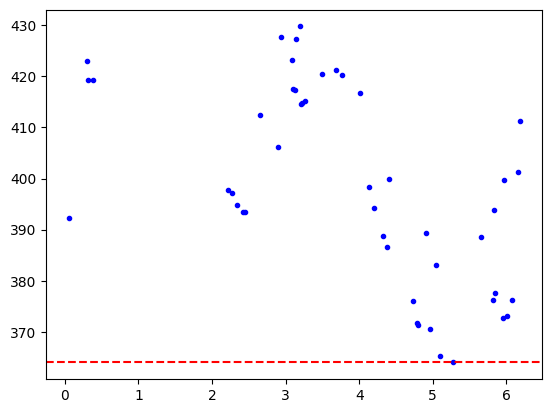

In [61]:
plt.plot(ang_arr_coll, m_fuel_arr_coll, 'b.')
plt.axhline(y=optim_fuel, color='r', linestyle='--')
plt.show()

In [ ]:
np.save('ang_arr_coll.npy', ang_arr_coll)
np.save('m_fuel_arr_coll.npy', m_fuel_arr_coll)

In [22]:
# ang_arr_coll = np.load('ang_arr_coll.npy')
# m_fuel_arr_coll = np.load('m_fuel_arr_coll.npy')
# optim_fuel = min(m_fuel_arr_coll)

In [27]:
opt_idx = m_fuel_arr_coll.argmin()

In [28]:
optim_fuel = m_fuel_arr_coll[opt_idx]
optim_ang = ang_arr_coll[opt_idx]

## Расчёт траектории по найденным оптимальным параметрам

In [29]:
m_cons = alpha * (optim_fuel + m_pg) / (1 - alpha)

def m_fuel(t):
    return 0 if t > t_fuel else optim_fuel * (t_fuel - t)/t_fuel

def m_r(t):
    return m_fuel(t) + m_cons + m_pg

def f_react(t, v):
    return np.zeros(2) if t > t_fuel else v * u * optim_fuel / (t_fuel*np.linalg.norm(v)*m_r(t))

def system_full(y, t):
    dydt0, dydt1, dydt2, dydt3, dydt4, dydt5, dydt6, dydt7 = y[8:]
    f_12 = f_gr(y[0:2], y[2:4])
    f_13 = f_gr(y[0:2], y[4:6])
    f_1r = f_gr(y[0:2], y[6:8])
    f_23 = f_gr(y[2:4], y[4:6])
    f_2r = f_gr(y[2:4], y[6:8])
    f_3r = f_gr(y[4:6], y[6:8])
    dydt8, dydt9 = m2*f_12 + m3*f_13 + m_r(t)*f_1r
    dydt10, dydt11 = -m1*f_12 + m3*f_23 + m_r(t)*f_2r
    dydt12, dydt13 = -m1*f_13 - m2*f_23 + m_r(t)*f_3r
    dydt14, dydt15 =  -m1*f_1r - m2*f_2r -m3*f_3r + f_react(t, y[14:16])
    return np.array([dydt0, dydt1, dydt2, dydt3, dydt4, dydt5, dydt6, dydt7, dydt8, dydt9, dydt10, dydt11, dydt12, dydt13, dydt14, dydt15])

r_r_init = np.array([r12, 0]) + np.array([r2+h, 0]) @ np.array([[np.cos(optim_ang), np.sin(optim_ang)], [-np.sin(optim_ang), np.cos(optim_ang)]])
v_r_init = np.array([0, v2]) + np.array([0, np.sqrt(g*m2/(r2+h))]) @ np.array([[np.cos(optim_ang), np.sin(optim_ang)], [-np.sin(optim_ang), np.cos(optim_ang)]])
init_cond = np.array([0,0, r12, 0, r12+r23, 0, r_r_init[0], r_r_init[1], 0, 0, 0, v2, 0, v2+v3, v_r_init[0], v_r_init[1]])

# init_cond = np.array([0,0, r12, 0, r12+r23, 0, r12+r2+h, 0, 0, 0, 0, v2, 0, v2+v3, 0, v2+np.sqrt(g*m2/(r2+h))])
assert len(init_cond) == 16

y_cur = init_cond.copy()
t_cur = 0.
# all_data = np.zeros((n, 16))

# orb_idx = -1
coll_idx = -1
# orb = False
coll = False

t_eval = np.linspace(0, t_end, n+1)
sol = odeint(system_full, init_cond, t_eval)

for j in range(n):
    if np.linalg.norm(sol[j,4:6] - sol[j,6:8]) <= r3:
        coll_idx = j
        coll = True
        break

(768, 16)


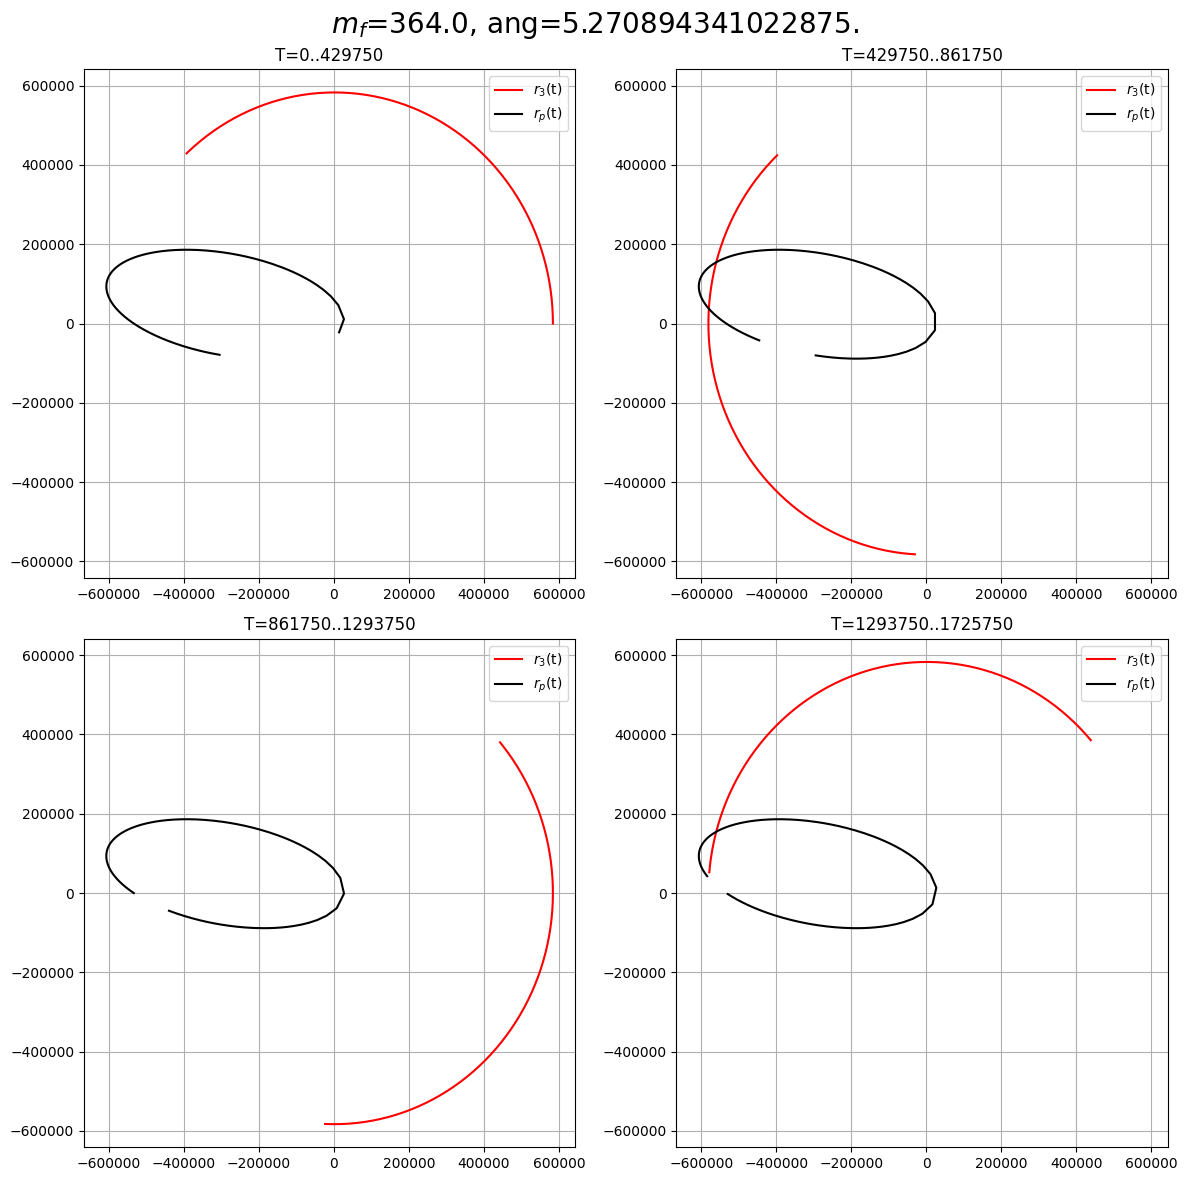

In [54]:
frames = 4
fig, ax = plt.subplots(2, 2, figsize = (6*2, 6*2), sharex=True, sharey=True)
all_data = sol[:coll_idx]
idxs = list(map(int, np.linspace(0, len(all_data)-1, frames+1)))
print(all_data.shape)
for fr, idx in enumerate(idxs[1:]):
    draw_data = all_data[idxs[fr]:idx]
    # ax[fr//2,fr%2].plot(draw_data[:,2]-draw_data[:,2], draw_data[:,3]-draw_data[:,3], 'b', label='$r_2$(t)')
    ax[fr//2,fr%2].plot(draw_data[:,4]-draw_data[:,2], draw_data[:,5]-draw_data[:,3], 'r', label='$r_3$(t)')
    ax[fr//2,fr%2].plot(draw_data[:,6]-draw_data[:,2], draw_data[:,7]-draw_data[:,3], 'k', label='$r_р$(t)')
    # plt.scatter(all_data[fuel_off_idx,6]-all_data[fuel_off_idx,2], all_data[fuel_off_idx,7]-all_data[fuel_off_idx,3], s=r3/50,c='r')
    ax[fr//2,fr%2].legend()
    ax[fr//2,fr%2].grid(True)
    ax[fr//2,fr%2].set_title('T={:.0f}..{:.0f}'.format(t_eval[idxs[fr]],t_eval[idx]))
    ax[fr//2,fr%2].xaxis.set_tick_params(labelbottom=True)
    ax[fr//2,fr%2].yaxis.set_tick_params(labelbottom=True)
fig.suptitle(f'$m_f$={optim_fuel}, ang={optim_ang}.', fontsize=20)
fig.tight_layout()
plt.show()

## Расчёт траекторий, при которых происходит столкновение

(319, 16)


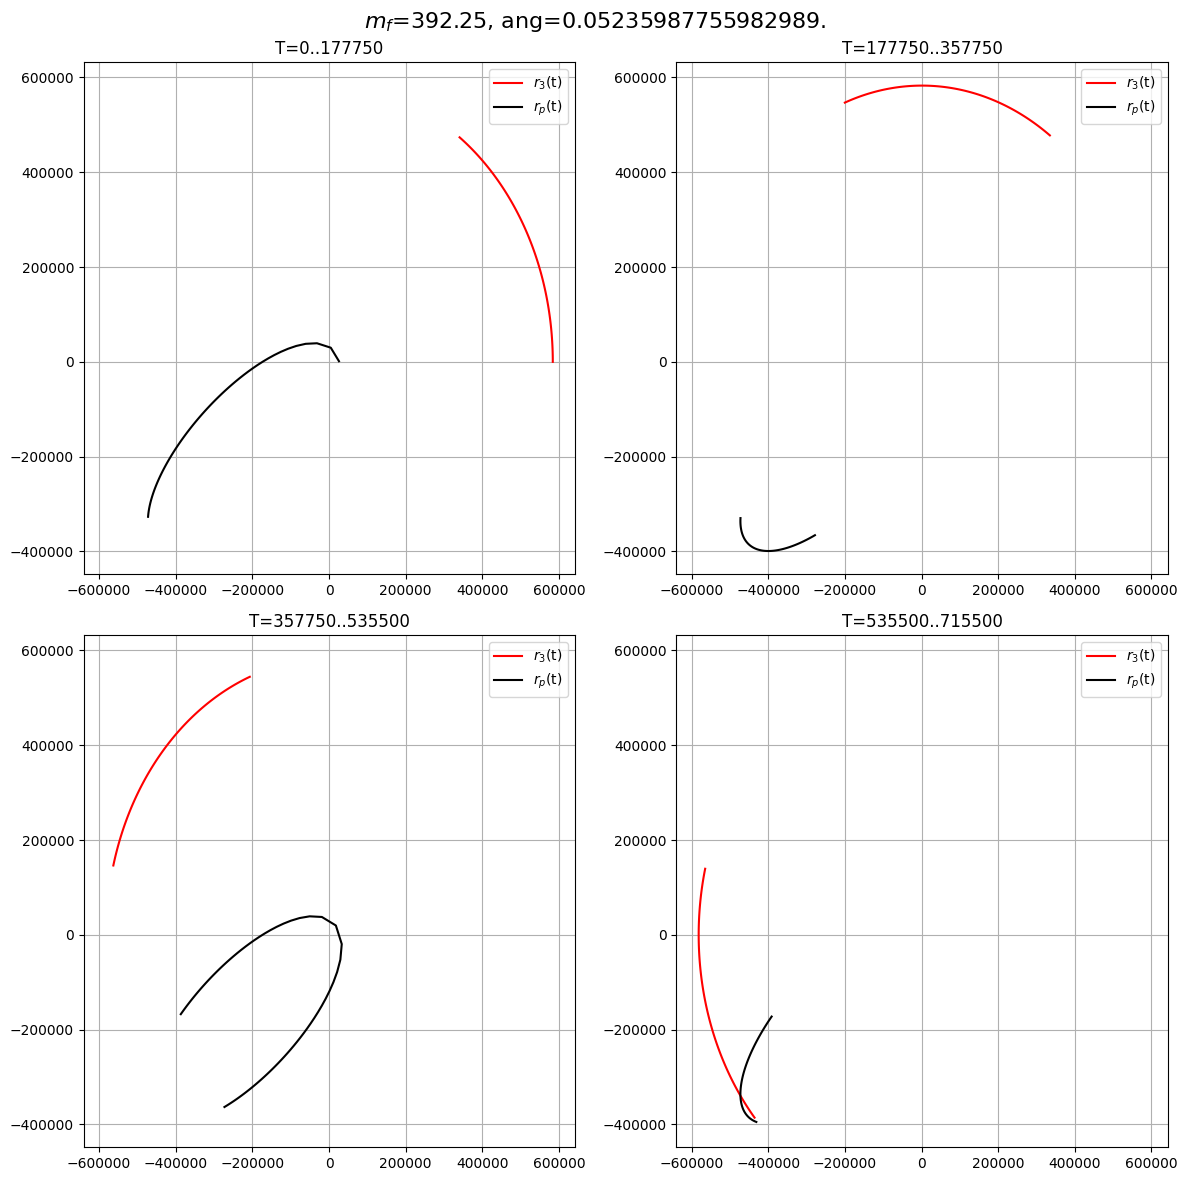

(513, 16)


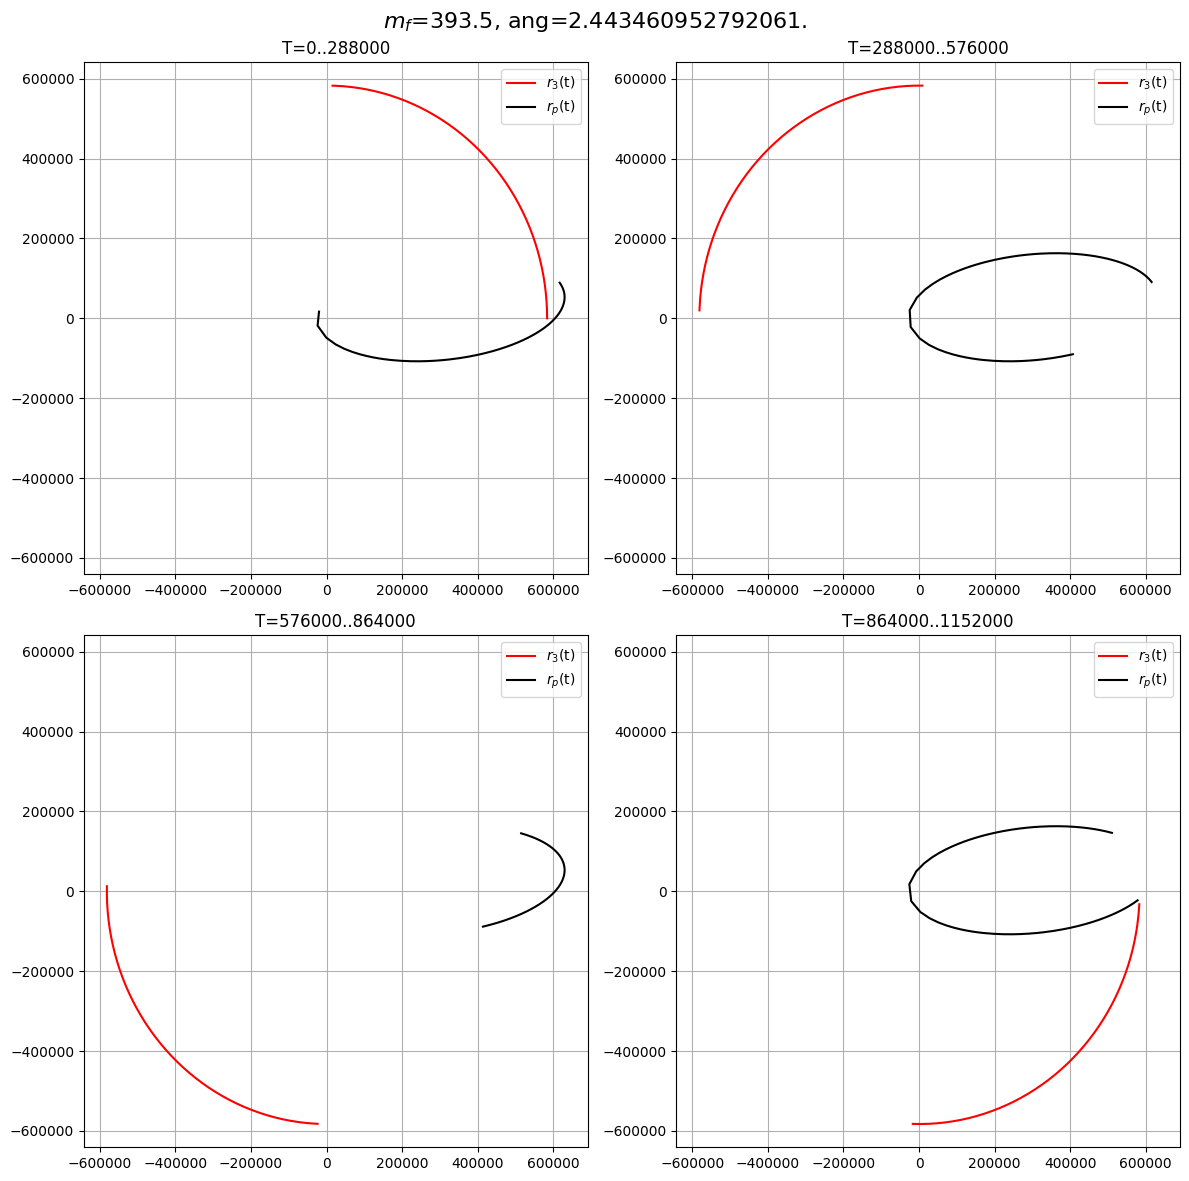

(590, 16)


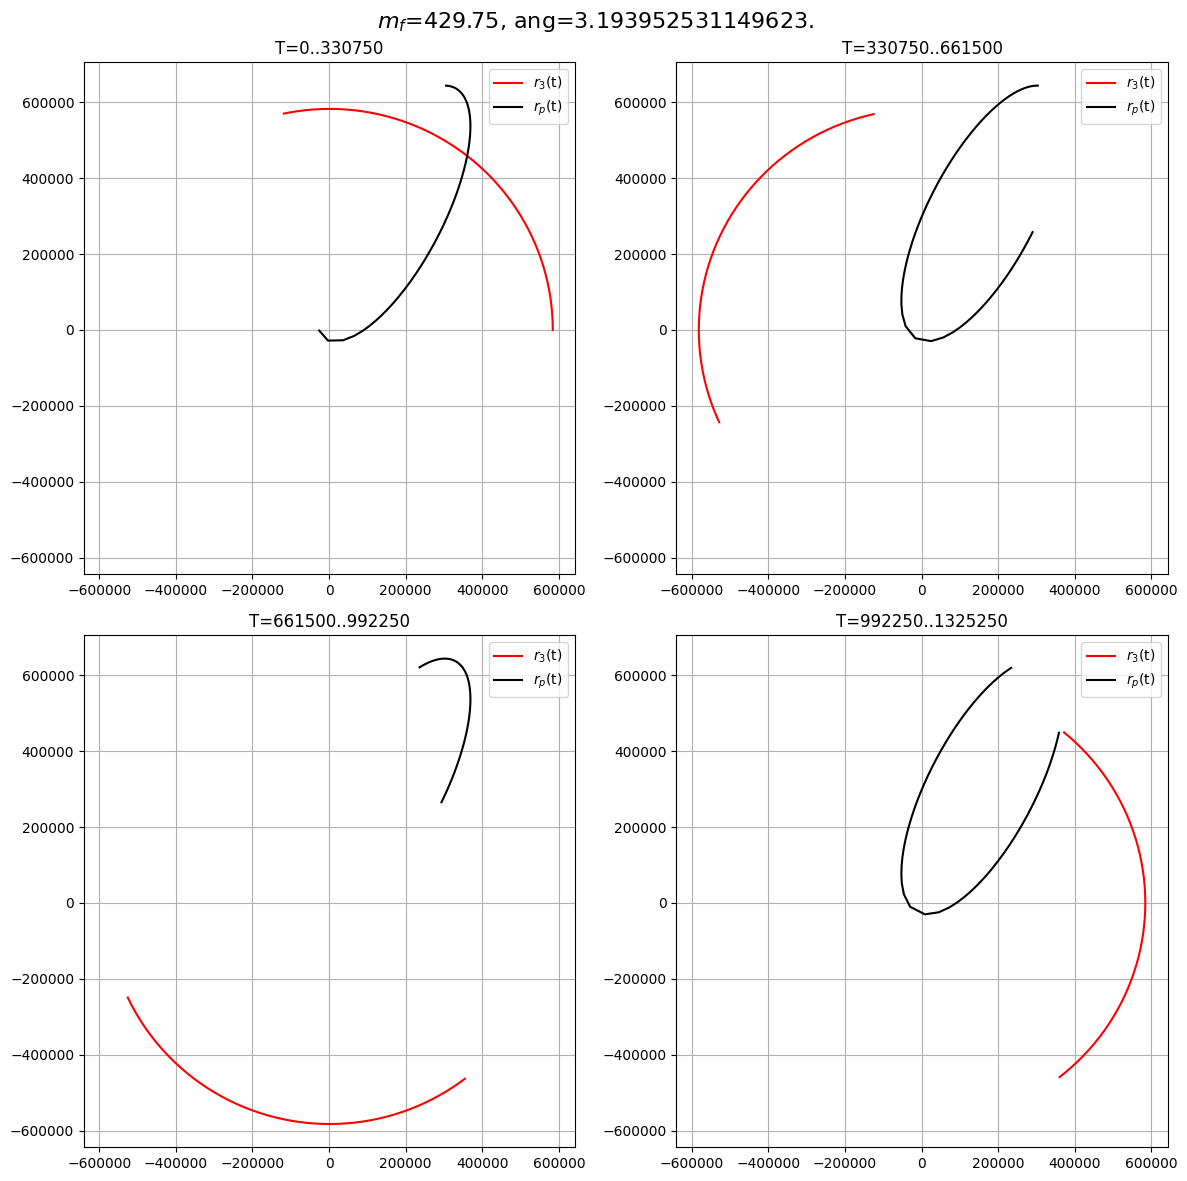

(680, 16)


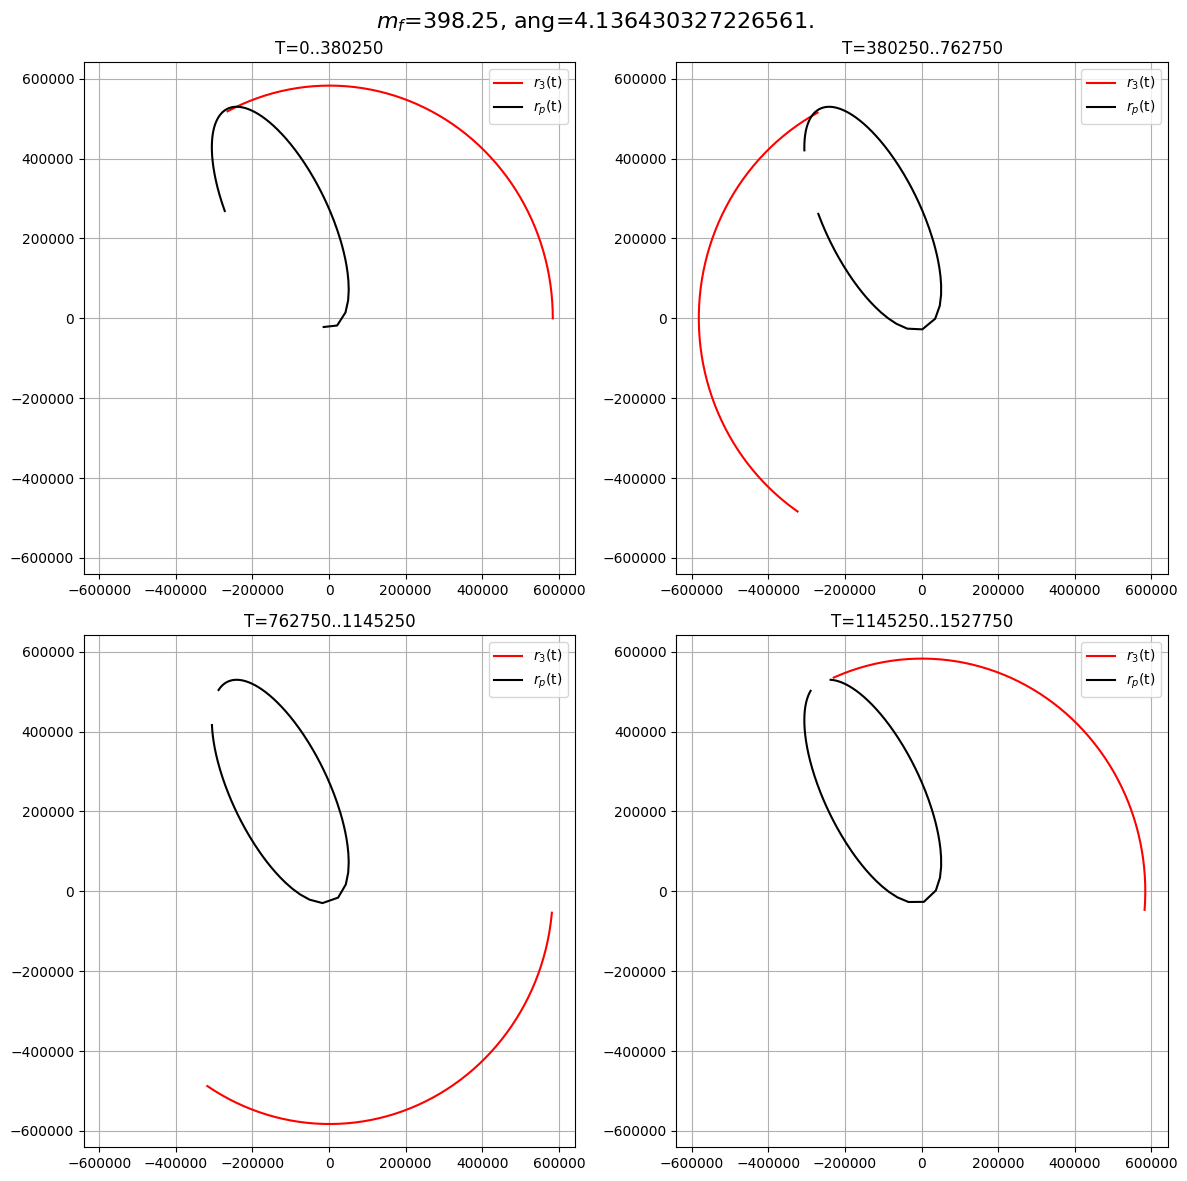

(716, 16)


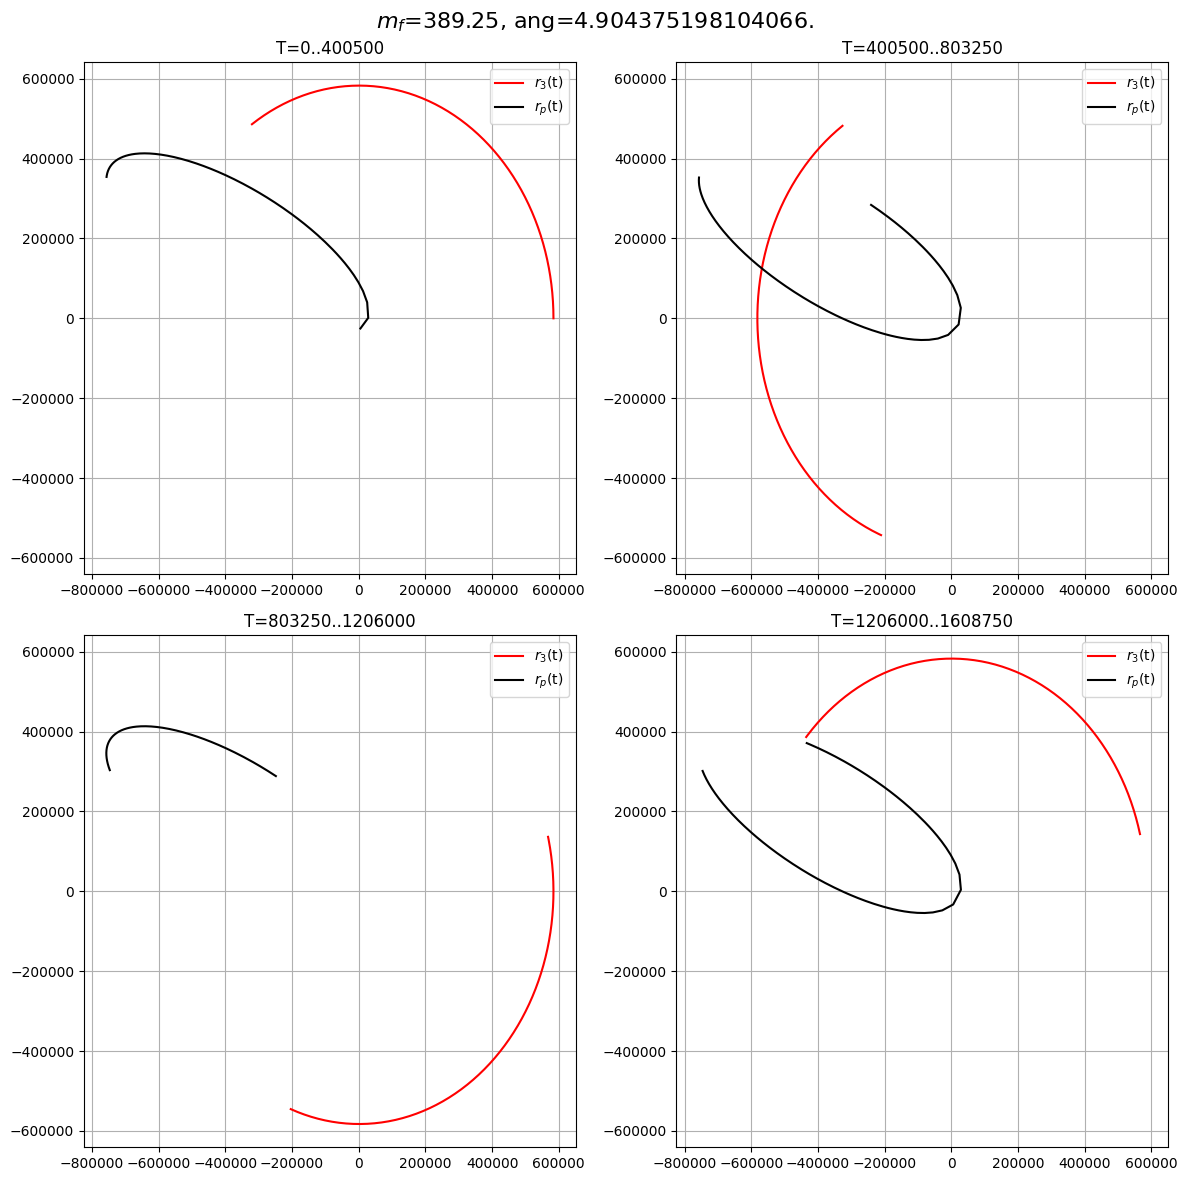

c:\Users\Ravil\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


(785, 16)


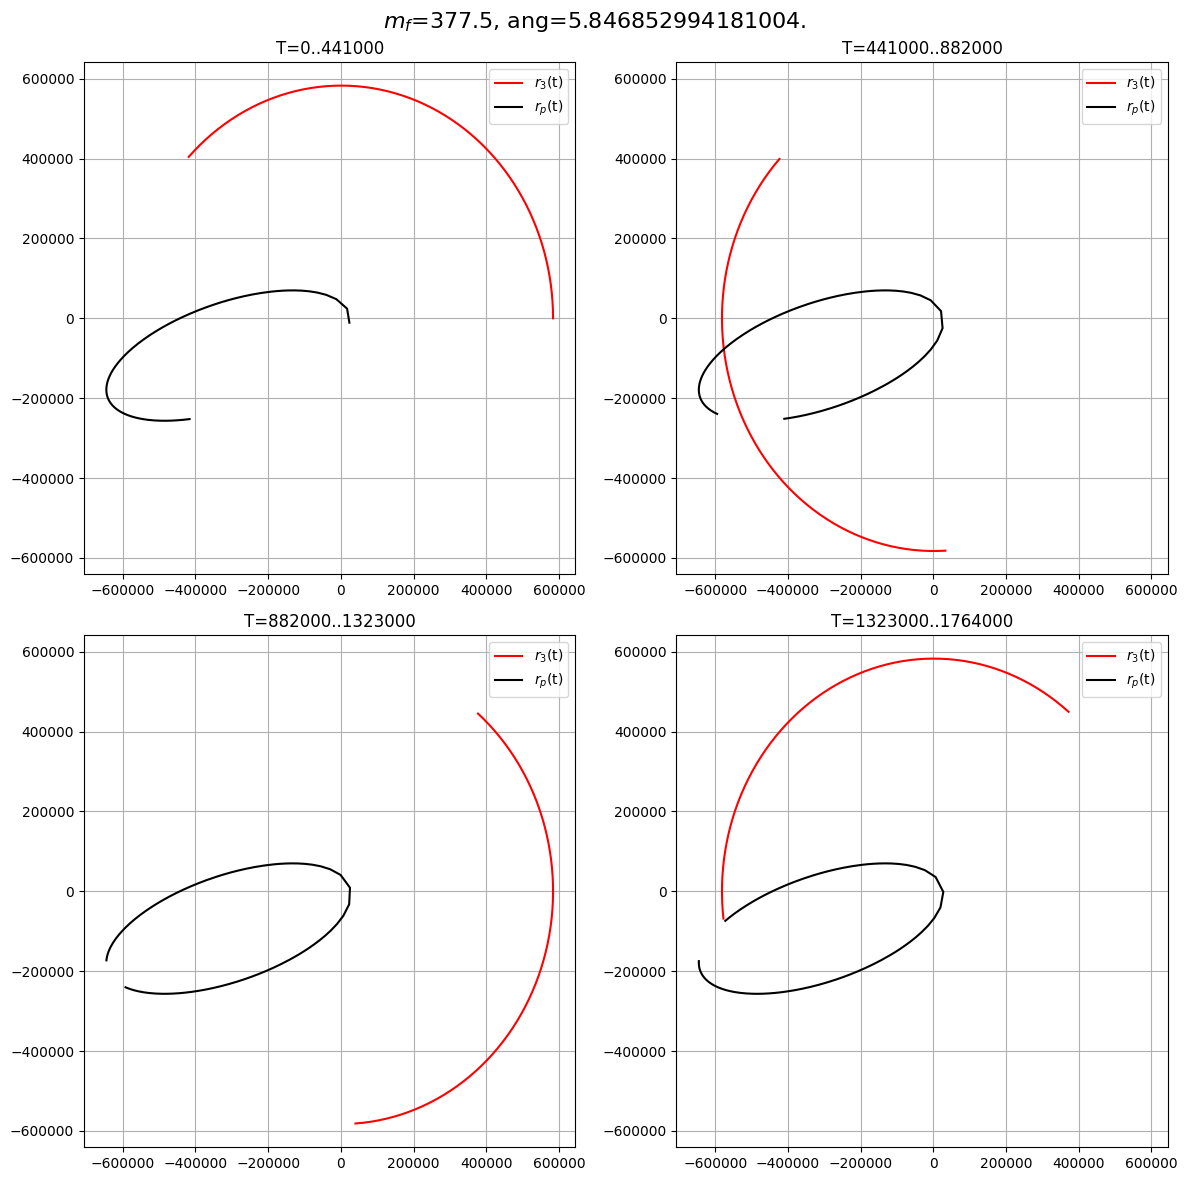

In [58]:
for f_val, cur_ang in list(zip(m_fuel_arr_coll,ang_arr_coll))[::8]:
    m_cons = alpha * (f_val + m_pg) / (1 - alpha)

    def m_fuel(t):
        return 0 if t > t_fuel else f_val * (t_fuel - t)/t_fuel

    def m_r(t):
        return m_fuel(t) + m_cons + m_pg

    def f_react(t, v):
        return np.zeros(2) if t > t_fuel else v * u * f_val / (t_fuel*np.linalg.norm(v)*m_r(t))

    def system_full(y, t):
        dydt0, dydt1, dydt2, dydt3, dydt4, dydt5, dydt6, dydt7 = y[8:]
        f_12 = f_gr(y[0:2], y[2:4])
        f_13 = f_gr(y[0:2], y[4:6])
        f_1r = f_gr(y[0:2], y[6:8])
        f_23 = f_gr(y[2:4], y[4:6])
        f_2r = f_gr(y[2:4], y[6:8])
        f_3r = f_gr(y[4:6], y[6:8])
        dydt8, dydt9 = m2*f_12 + m3*f_13 + m_r(t)*f_1r
        dydt10, dydt11 = -m1*f_12 + m3*f_23 + m_r(t)*f_2r
        dydt12, dydt13 = -m1*f_13 - m2*f_23 + m_r(t)*f_3r
        dydt14, dydt15 =  -m1*f_1r - m2*f_2r -m3*f_3r + f_react(t, y[14:16])
        return np.array([dydt0, dydt1, dydt2, dydt3, dydt4, dydt5, dydt6, dydt7, dydt8, dydt9, dydt10, dydt11, dydt12, dydt13, dydt14, dydt15])

    r_r_init = np.array([r12, 0]) + np.array([r2+h, 0]) @ np.array([[np.cos(cur_ang), np.sin(cur_ang)], [-np.sin(cur_ang), np.cos(cur_ang)]])
    v_r_init = np.array([0, v2]) + np.array([0, np.sqrt(g*m2/(r2+h))]) @ np.array([[np.cos(cur_ang), np.sin(cur_ang)], [-np.sin(cur_ang), np.cos(cur_ang)]])
    init_cond = np.array([0,0, r12, 0, r12+r23, 0, r_r_init[0], r_r_init[1], 0, 0, 0, v2, 0, v2+v3, v_r_init[0], v_r_init[1]])

    # init_cond = np.array([0,0, r12, 0, r12+r23, 0, r12+r2+h, 0, 0, 0, 0, v2, 0, v2+v3, 0, v2+np.sqrt(g*m2/(r2+h))])
    assert len(init_cond) == 16

    y_cur = init_cond.copy()
    t_cur = 0.
    # all_data = np.zeros((n, 16))

    # orb_idx = -1
    coll_idx = -1
    # orb = False
    coll = False

    t_eval = np.linspace(0, t_end, n+1)
    sol = odeint(system_full, init_cond, t_eval)

    for j in range(n):
        if np.linalg.norm(sol[j,4:6] - sol[j,6:8]) <= r3:
            coll_idx = j
            coll = True
            break

    frames = 4
    fig, ax = plt.subplots(2, 2, figsize = (6*2, 6*2), sharex=True, sharey=True)
    all_data = sol[:coll_idx]
    idxs = list(map(int, np.linspace(0, len(all_data)-1, frames+1)))
    print(all_data.shape)
    for fr, idx in enumerate(idxs[1:]):
        draw_data = all_data[idxs[fr]:idx]
        # ax[fr//2,fr%2].plot(draw_data[:,2]-draw_data[:,2], draw_data[:,3]-draw_data[:,3], 'b', label='$r_2$(t)')
        ax[fr//2,fr%2].plot(draw_data[:,4]-draw_data[:,2], draw_data[:,5]-draw_data[:,3], 'r', label='$r_3$(t)')
        ax[fr//2,fr%2].plot(draw_data[:,6]-draw_data[:,2], draw_data[:,7]-draw_data[:,3], 'k', label='$r_р$(t)')
        # plt.scatter(all_data[fuel_off_idx,6]-all_data[fuel_off_idx,2], all_data[fuel_off_idx,7]-all_data[fuel_off_idx,3], s=r3/50,c='r')
        ax[fr//2,fr%2].legend()
        ax[fr//2,fr%2].grid(True)
        ax[fr//2,fr%2].set_title('T={:.0f}..{:.0f}'.format(t_eval[idxs[fr]],t_eval[idx]))
        ax[fr//2,fr%2].xaxis.set_tick_params(labelbottom=True)
        ax[fr//2,fr%2].yaxis.set_tick_params(labelbottom=True)
    fig.suptitle(f'$m_f$={f_val}, ang={cur_ang}.', fontsize=16)
    fig.tight_layout()
    plt.show()

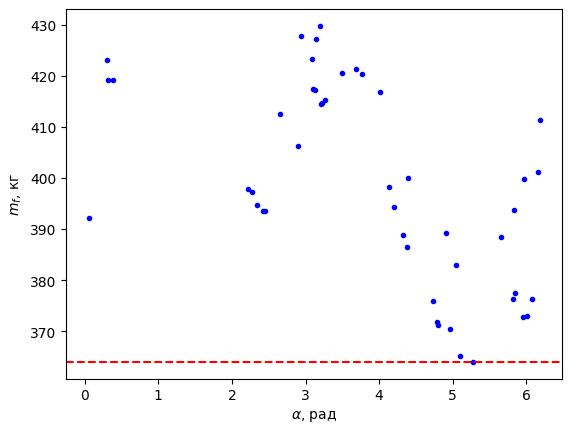

In [69]:
plt.plot(ang_arr_coll, m_fuel_arr_coll, 'b.')
plt.axhline(y=optim_fuel, color='r', linestyle='--')
plt.xlabel('$\\alpha$, рад')
plt.ylabel('$m_{f}$, кг')
plt.show()

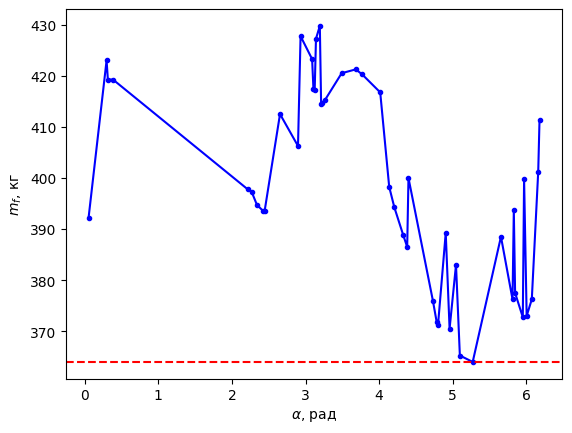

In [73]:
plt.plot(ang_arr_coll, m_fuel_arr_coll, 'b-')
plt.plot(ang_arr_coll, m_fuel_arr_coll, 'b.')
plt.axhline(y=optim_fuel, color='r', linestyle='--')
plt.xlabel('$\\alpha$, рад')
plt.ylabel('$m_{f}$, кг')
plt.show()